In [ ]:
import numpy as np
np.random.seed(0)

# Evaluate on synthetic data

In [ ]:
N = 100
nb_epoch = 2000
batch_size = 20
nb_features = 1024
Q = 1
D1 = 1  # first output
D2 = 1  # second output

In [ ]:
def gen_data(N):
    X = np.random.randn(N, Q)
    w1 = 2.
    b1 = 8.
    sigma1 = 10  # ground truth
    Y1 = X.dot(w1) + b1 + sigma1 * np.random.randn(N, D1)
    w2 = 3
    b2 = 3.
    sigma2 = 1  # ground truth
    Y2 = X.dot(w2) + b2 + sigma2 * np.random.randn(N, D2)
    return X, Y1, Y2

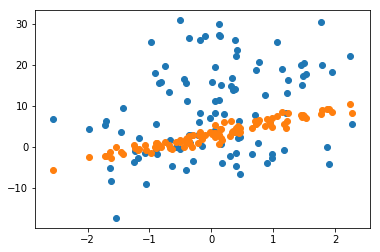

In [ ]:
import matplotlib.pyplot as plt
%matplotlib inline

X, Y1, Y2 = gen_data(N)
plt.figure()
plt.scatter(X[:, 0], Y1[:, 0])
plt.scatter(X[:, 0], Y2[:, 0])
plt.show()

# Multi loss layer

# Example model

In [ ]:
from keras.layers import Input, Dense
from keras.models import Model

from egosocial.utils.keras.autolosses import AutoMultiLossWrapper

# model example
def get_prediction_model():
    inp = Input(shape=(Q,), name='input')
    x = Dense(nb_features, activation='relu')(inp)  
    y1_pred = Dense(D1, name='y1')(x)
    y2_pred = Dense(D2, name='y2')(x)
    return Model(inp, [y1_pred, y2_pred])

auto_ml_wrapper = AutoMultiLossWrapper(get_prediction_model())

# identical to model.compile except that accepts loss_weights='auto'
auto_ml_wrapper.compile(optimizer='adam',
                        loss='mse',
#                        loss={'y1': 'mse', 'y2': 'mse'},
#                        loss=['mse', 'mse'],
                        loss_weights='auto'
                       )

In [ ]:
# the extended model contains the dummy layer at the end
trainable_model = auto_ml_wrapper.model
trainable_model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input (InputLayer)              (None, 1)            0                                            
__________________________________________________________________________________________________
dense_1 (Dense)                 (None, 1024)         2048        input[0][0]                      
__________________________________________________________________________________________________
y1 (Dense)                      (None, 1)            1025        dense_1[0][0]                    
__________________________________________________________________________________________________
y2 (Dense)                      (None, 1)            1025        dense_1[0][0]                    
__________________________________________________________________________________________________
auto_loss_

In [9]:
# train extended model
# deals with the dummy output internally
hist = trainable_model.fit(X, [Y1, Y2], 
                           epochs=nb_epoch, batch_size=batch_size, 
                           verbose=0)

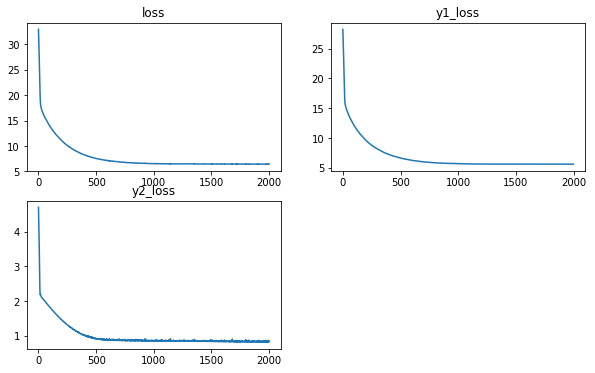

In [10]:
# auto weighted multi-loss
plt.figure(figsize=(10, 6))
for idx, loss_name in enumerate(hist.history):
    plt.subplot(2,2,idx+1)
    plt.plot(hist.history[loss_name])
    plt.title(loss_name)

In [12]:
# Found standard deviations (ground truth is 10 and 1)
auto_ml_wrapper.get_sigma()

[9.993548410182449, 0.9203630754080946]

In [13]:
# original model can be used for predictions
prediction_model = auto_ml_wrapper.original_model
prediction_model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input (InputLayer)              (None, 1)            0                                            
__________________________________________________________________________________________________
dense_1 (Dense)                 (None, 1024)         2048        input[0][0]                      
__________________________________________________________________________________________________
y1 (Dense)                      (None, 1)            1025        dense_1[0][0]                    
__________________________________________________________________________________________________
y2 (Dense)                      (None, 1)            1025        dense_1[0][0]                    
Total params: 4,098
Trainable params: 4,098
Non-trainable params: 0
_________________________________________

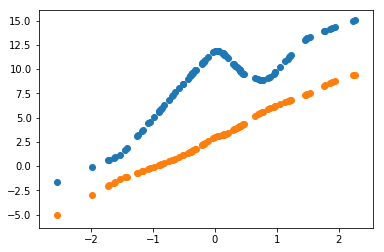

In [14]:
import matplotlib.pyplot as plt
%matplotlib inline

Y1_pred, Y2_pred = prediction_model.predict(X)
plt.figure()
plt.scatter(X[:, 0], Y1_pred[:, 0])
plt.scatter(X[:, 0], Y2_pred[:, 0])
plt.show()